# Simulation

[[1]](https://github.com/eitcom/pyEIT)

In [335]:
# coding: utf-8
""" demo on forward 2D """
# Copyright (c) Benyuan Liu. All Rights Reserved.
# Distributed under the (new) BSD License. See LICENSE.txt for more info.
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
from pyeit.eit.fem import EITForward, Forward
from pyeit.eit.interp2d import pdegrad, sim2pts
from pyeit.mesh.shape import thorax
from pyeit.mesh.wrapper import PyEITAnomaly_Circle

from src.util import plot_mesh

In [336]:
#helper = []
#helper.append()

#helper2 = np.array()


In [337]:
""" 0. build mesh """

n_el = 16  # nb of electrodes
use_customize_shape = False
if use_customize_shape:
    # Mesh shape is specified with fd parameter in the instantiation, e.g : fd=thorax
    mesh_obj = mesh.create(n_el, h0=0.05, fd=thorax)
else:
    mesh_obj = mesh.create(n_el, h0=0.05)
el_pos = mesh_obj.el_pos

# extract node, element, alpha
pts = mesh_obj.node
tri = mesh_obj.element
x, y = pts[:, 0], pts[:, 1]
mesh_obj.print_stats()


def calculateData (mesh):
    protocol_obj = protocol.create(n_el, dist_exc=4, step_meas=1, parser_meas="std")
    ex_line = protocol_obj.ex_mat[3].ravel() #? keine Ahnung was das macht 
    fwd = Forward(mesh)
    f = fwd.solve(ex_line)
    fwd = EITForward(mesh_obj, protocol_obj)
    f = np.real(f)
    v = fwd.solve_eit(perm=mesh.perm)   #berechnet den Potentialvektor (192 Werte)
    return (f, v)

# Erstellt die einzelnen Positionen der Anomalie (abhängig von der Anzahl "Nsteps"), Größe der Anomalie über r definierbar, Radius der Kreisbahn mit r_path einstellbar 
def createAnomaly (Nsteps,r,r_path):
    anglePos = np.linspace(0, 2*np.pi, Nsteps)           # P(cos(alpha)=x, sin(alpha)=y)
    perm=100.0
    mesh_new_list = []
    for a in anglePos:
        anomaly = PyEITAnomaly_Circle(center=[np.cos(a)*r_path,np.sin(a)*r_path], r=r, perm=perm) #erstellt Anomalie an den einzelnen Positionen/Winkeln
        anomaly_mesh = mesh.set_perm(mesh_obj, anomaly=anomaly, background=1.0)
        f, v = calculateData(anomaly_mesh)
        mesh_dict = {"mesh": anomaly_mesh, "x":np.cos(a)*r_path, "y":np.sin(a)*r_path, "radius":r, "perm_init":perm, "f":f, "v":v}
        mesh_new_list.append(mesh_dict) #erstellt eine Liste aus den Mesh-Dict Daten
        #perm = mesh_new.perm    
    return mesh_new_list


2D mesh status:
1476 nodes, 2821 elements


In [338]:
mesh_new_list = createAnomaly(10,0.2,0.5)


In [339]:
mesh_new_list[0]["f"].shape#['mesh']

(1476,)

In [340]:
mesh_new_list[0]["v"].shape

(192,)

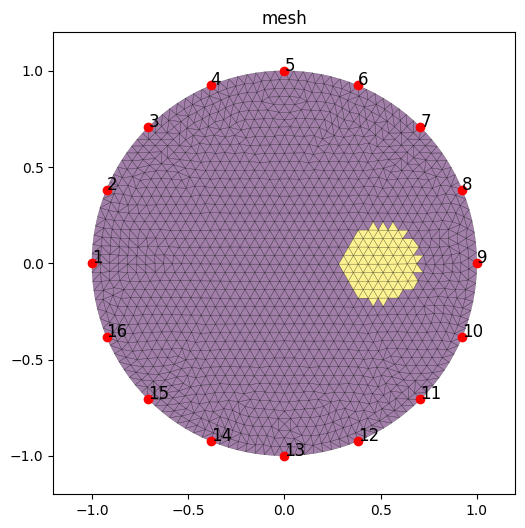

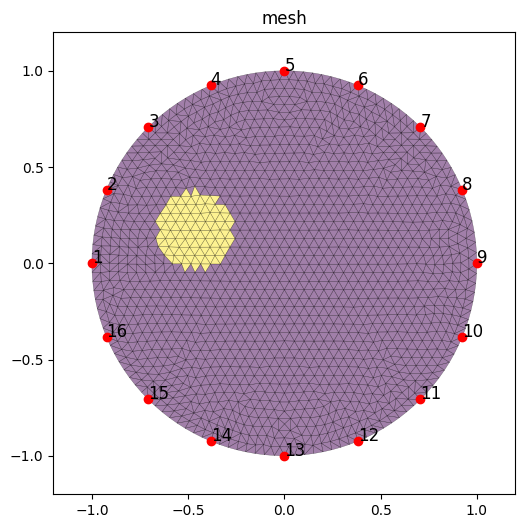

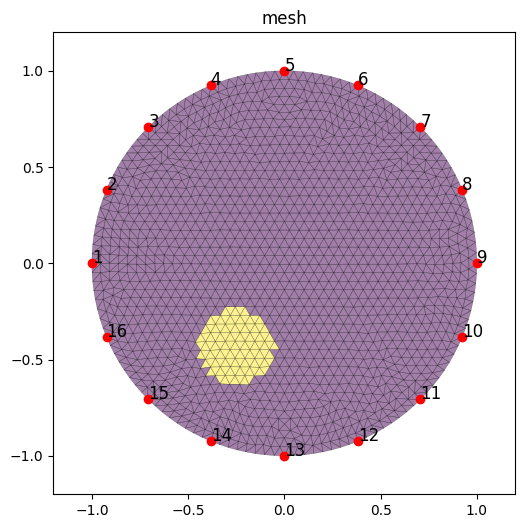

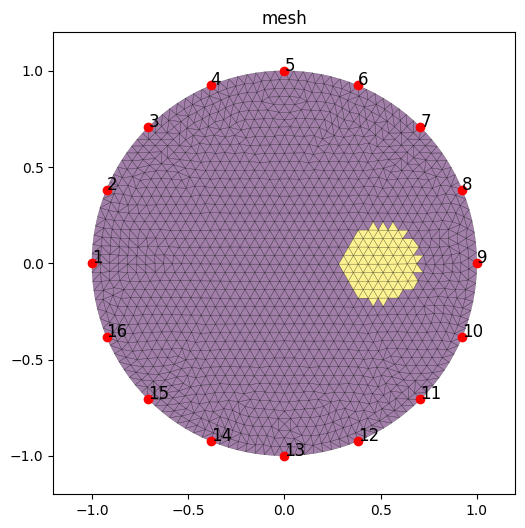

In [341]:
mesh_new_list = createAnomaly(10,0.2,0.5) 

plot_mesh(mesh_new_list[0]["mesh"])
plot_mesh(mesh_new_list[4]["mesh"])
plot_mesh(mesh_new_list[6]["mesh"])
plot_mesh(mesh_new_list[9]["mesh"])



In [ ]:
""" 2. plot """

def createAnimation(mesh_new_list):
    # draw equi-potential lines
    for i in range(len(mesh_new_list)):
        fig, ax1 = plt.subplots(figsize=(9, 6))
        vf = np.linspace(min(mesh_new_list[i]["f"]), max(mesh_new_list[i]["f"]), 64)
        # vf = np.sort(f[el_pos])
        # Draw contour lines on an unstructured triangular grid.
        ax1.tricontour(x, y, tri, mesh_new_list[i]["f"], vf, cmap=plt.cm.viridis)

        # draw mesh structure
        # Create a pseudocolor plot of an unstructured triangular grid
        ax1.tripcolor(
                x,
                y,
                tri,
                np.real(mesh_new_list[i]["mesh"].perm),
                edgecolors="k",
                shading="flat",
                alpha=0.5,
                cmap=plt.cm.Greys,
        )
        # draw electrodes
        ax1.plot(x[el_pos], y[el_pos], "ro")
        for i, e in enumerate(el_pos):
            ax1.text(x[e], y[e], str(i + 1), size=12)
        ax1.set_title("equi-potential lines")
        
        
        # clean up
        ax1.set_aspect("equal")
        ax1.set_ylim([-1.2, 1.2])
        ax1.set_xlim([-1.2, 1.2])
        fig.set_size_inches(6, 6)
        # fig.savefig('demo_bp.png', dpi=96)
        plt.show()

       # ux, uy = pdegrad(pts, tri, f)
       # uf = ux**2 + uy**2
       # uf_pts = sim2pts(pts, tri, uf)
        # uf_logpwr = 10 * np.log10(uf_pts)

        #fig, ax = plt.subplots(figsize=(9, 6))
        # Draw contour lines on an unstructured triangular grid.
        #ax.tripcolor(x, y, tri, uf_logpwr, cmap=plt.cm.viridis)
        #ax.tricontour(x, y, tri, uf_logpwr, 10, cmap=plt.cm.hot)
        #ax.set_aspect("equal")
        #ax.set_ylim([-1.2, 1.2])
        #ax.set_xlim([-1.2, 1.2])
        #ax.set_title("E field (logmag)")
        #plt.show()

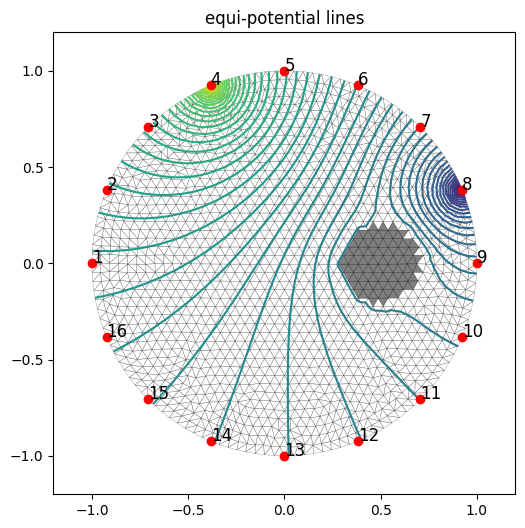

In [345]:
createAnimation(mesh_new_list)

**save data**

In [ ]:
for phi in range(10):
    # create mesh
    # change anomaly
    # solve forward ->v
    np.savez("data/sample_{0:06d}.npz".format(phi), v=v1, anomalie=anomaly)

FileNotFoundError: [Errno 2] No such file or directory: 'data/sample_000000.npz'

**load data**

In [ ]:
from glob import glob

In [ ]:
file_list = np.sort(glob("data/*.npz"))

In [ ]:
V = list()  # voltages
A = list()  # anomalies
for file in file_list:
    tmp = np.load(file, allow_pickle=True)
    V.append(tmp["v"])
    A.append(tmp["anomalie"].tolist())

In [ ]:
A

[PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2)]

In [ ]:
A[3]

PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2)

In [ ]:
A[3].r

0.2